Epoch 1/30
2/2 [==============================] - 5s 2s/step - loss: 12.5054 - accuracy: 0.8571 - val_loss: 41.4990 - val_accuracy: 0.7692
Epoch 2/30
2/2 [==============================] - 5s 2s/step - loss: 18.7901 - accuracy: 0.8571 - val_loss: 10.6283 - val_accuracy: 0.7692
Epoch 3/30
2/2 [==============================] - 4s 2s/step - loss: 2.5566 - accuracy: 0.8980 - val_loss: 9.5429 - val_accuracy: 0.2308
Epoch 4/30
2/2 [==============================] - 4s 2s/step - loss: 6.6990 - accuracy: 0.4082 - val_loss: 5.9500 - val_accuracy: 0.7692


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 326ms/step - loss: 41.4990 - accuracy: 0.7692
Precisión en el conjunto de prueba: 0.7692307829856873
1/1 [==============================] - 0s 425ms/step


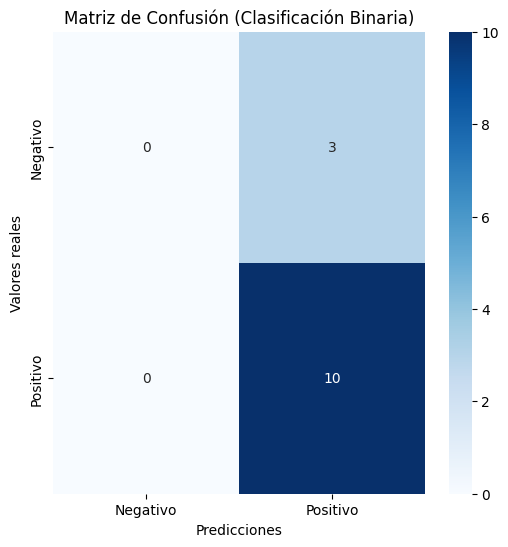

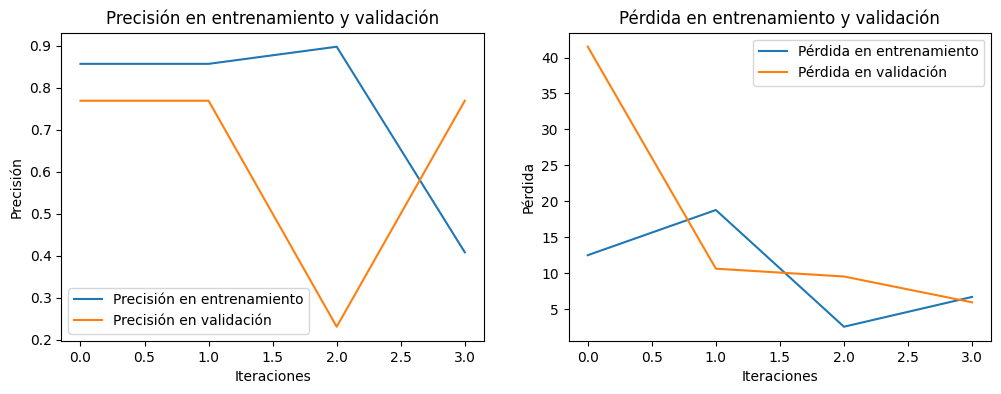

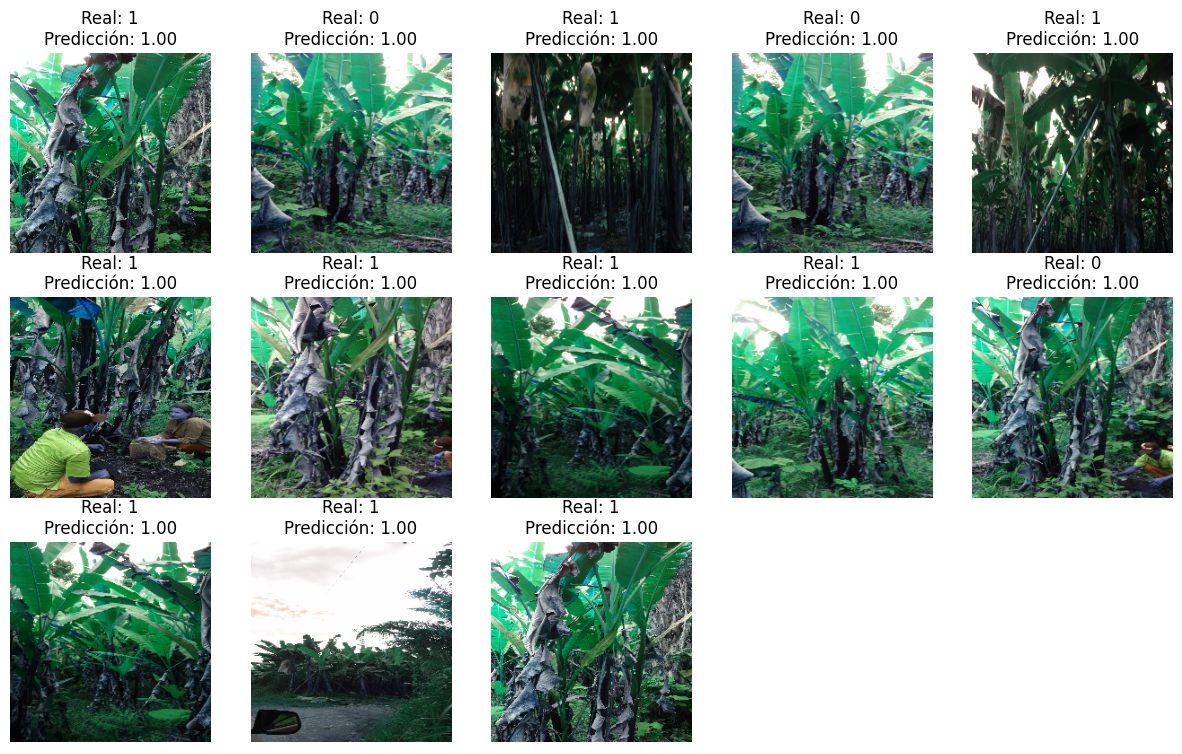

In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping

# Rutas a las carpetas de imágenes
ruta_positivas = '/content/drive/MyDrive/Modelado/positivo'
ruta_negativas = '/content/drive/MyDrive/Modelado/negativo'

# Lista para almacenar las imágenes y las etiquetas
imagenes = []
etiquetas = []

# Función para cargar y preprocesar imágenes
def cargar_y_preprocesar_imagen(ruta, etiqueta):
    for archivo in os.listdir(ruta):
        if archivo.endswith('.JPG'):  # Asumiendo que las imágenes son archivos jpg
            imagen = cv2.imread(os.path.join(ruta, archivo))
            imagen = cv2.resize(imagen, (224, 224))
            imagen = imagen.astype('float32') / 255.0
            imagenes.append(imagen)
            etiquetas.append(etiqueta)

# Cargar imágenes positivas
cargar_y_preprocesar_imagen(ruta_positivas, etiqueta=1)

# Cargar imágenes negativas
cargar_y_preprocesar_imagen(ruta_negativas, etiqueta=0)

# Convertir listas a numpy arrays
imagenes = np.array(imagenes)
etiquetas = np.array(etiquetas)

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(imagenes, etiquetas, test_size=0.2, random_state=42)

# Crear el modelo CNN con regularización L2
modelo = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),  # Regularización L2
    layers.Dense(1, activation='sigmoid')  # Salida binaria
])

# Compilar el modelo
modelo.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])

# Callback para detener el entrenamiento temprano si la precisión en validación deja de mejorar
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

# Entrenar el modelo con el callback de EarlyStopping
historia = modelo.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Guardar el modelo entrenado
modelo.save("modelo_moko.h5")

# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = modelo.evaluate(X_test, y_test)
print(f'Precisión en el conjunto de prueba: {test_accuracy}')

# Realizar predicciones
y_pred = modelo.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)
y_true = y_test

# Crear matriz de confusión
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negativo', 'Positivo'],
            yticklabels=['Negativo', 'Positivo'])
plt.xlabel('Predicciones')
plt.ylabel('Valores reales')
plt.title('Matriz de Confusión (Clasificación Binaria)')
plt.show()

# Gráfica de entrenamiento
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(historia.history['accuracy'], label='Precisión en entrenamiento')
plt.plot(historia.history['val_accuracy'], label='Precisión en validación')
plt.xlabel('Iteraciones')
plt.ylabel('Precisión')
plt.legend()
plt.title('Precisión en entrenamiento y validación')

plt.subplot(1, 2, 2)
plt.plot(historia.history['loss'], label='Pérdida en entrenamiento')
plt.plot(historia.history['val_loss'], label='Pérdida en validación')
plt.xlabel('Iteraciones')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Pérdida en entrenamiento y validación')
plt.show()

# Mostrar todas las imágenes con etiquetas y predicciones
num_imagenes = len(X_test)
num_filas = (num_imagenes // 5) + 1  # Ajustar el número de filas para acomodar todas las imágenes

plt.figure(figsize=(15, num_filas * 3))
for i in range(num_imagenes):
    plt.subplot(num_filas, 5, i + 1)
    plt.imshow(X_test[i])
    plt.title(f'Real: {y_true[i]}\nPredicción: {y_pred_classes[i][0]:.2f}')
    plt.axis('off')

# Asegúrate de que las celdas restantes estén en blanco
for i in range(num_imagenes, num_filas * 5):
    plt.subplot(num_filas, 5, i + 1)
    plt.axis('off')

plt.show()